# 现代计算机体系结构

大数据与人工智能应用对算力要求极高，为应对飞速增长的算力需求，芯片与硬件厂商近年来重点发展多核、集群（Cluster）和异构计算（Heterogeneous Computing）。

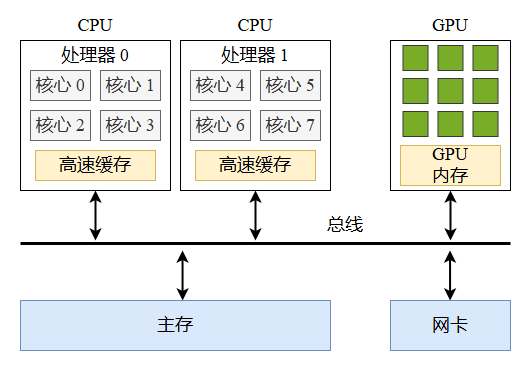

所谓多核指的是一台计算机上有多颗中央处理器（Central Processing Unit，CPU），每个 CPU 有多个计算核心（Core）。CPU 内部有自己的缓存，比如一级缓存（Level 1 Cache，L1 Cache）或二级缓存（Level 2 Cache，L2 Cache），CPU 外部有主存（Main Memory）。

所谓集群指多台计算机通过高速网络互联，每台计算机上都配置了网卡（Network Interface Card，NIC）。

近年来，以 GPU 为代表的异构计算异军突起，成为人工智能算力核心。异构计算指在 CPU 芯片微架构（Microarchitecture）基础上，引入图形处理器（Graphics Processing Units），现场可编程门阵列（Field Programmable Gate Array，FPGA）等另一套芯片微架构。其中，CPU 仍然负责传统的处理和调度，GPU 等设备被用来加速某些特定的任务，比如图形图像、人工智能、区块链等。

## CPU

现代 CPU 通常有多个计算核心，比如，笔记本电脑和台式机最多可拥有十几个计算核心，数据中心服务器高达上百个核心。然而，如何让计算任务分布到多个核心上并不简单，需要程序员在编写软件时将计算任务合理地调度到不同核心上。

## 网卡

单台计算机的计算能力有限，为搭建一个高速互联的集群，数据中心服务器之间通常配置了高速网络，比如 RoCE（RDMA over Converged Ethernet）或 InfiniBand。每台计算机上配有至少一块高速网卡，多台计算机之间通过光纤互联，以获得极低的延迟和极高的吞吐率。这样不同节点之间互相访问数据就像在单个节点一样。

## 异构计算

在异构计算的框架下，CPU 和主存通常被称为主机（Host），各类专用的加速器被称为设备（Device）。尽管异构计算是一个很宽泛的概念，但当前基于 GPU 的异构计算是主流，尤其是以英伟达为代表的 GPU 占据了大量市场份额，所以这里主要以 GPU 为例介绍异构计算。GPU 有区别于 CPU 的芯片微架构和编译软件栈。软件层面，英伟达的 GPU 提供了 CUDA（Compute Unified Device Architecture）编程接口，硬件层面，GPU 有很多个专用计算核心（CUDA Core 或 Tensor Core）和 GPU 上的存储（GPU Memory）。通常，数据从主存到 GPU 存储之间搬运有一定时间成本。其他加速器与英伟达 GPU 架构有相似之处。

# 串行执行与并行执行

如果不对计算任务（Task）进行并行加速，大部分计算任务是串行执行的，即下图所示。这里的 Worker 可以是一个计算核心，也可以是集群中的一个节点。

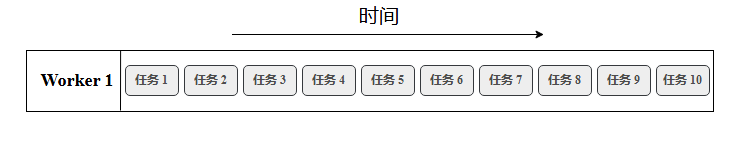

集群和异构计算提供了更多可利用的计算核心，并行计算将计算任务分布到多个 Worker 上，如下图所示。无论是在单机多核编程，还是在集群多机，都需要一个调度器（Scheduler）将计算任务分布到不同的 Worker 上。随着更多 Worker 参与，任务总时间缩短，节省的时间可用于其他任务。

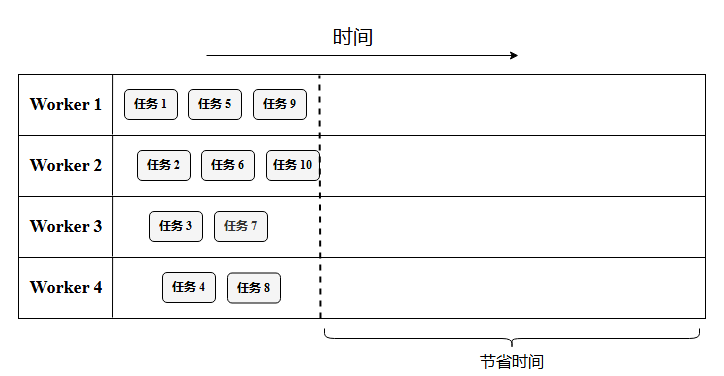

# 线程和进程

CPU、GPU、网卡等都是硬件层面上的概念，在软件层面，经常使用线程（Thread）或进程（Process）来描述程序的运行过程。

CPU、GPU、网卡等都是被操作系统（Operating System，OS）管理的。操作系统一方面管理硬件，另一方面通过各类应用软件为用户提供服务。**正在运行的软件就是进程（Process）**。以个人的笔记本电脑为例，使用浏览器浏览网页时，操作系统创建了一个浏览器的进程；使用文本编辑软件 Word 编写文字内容时，操作系统创建了一个 Word 进程。macOS 上的活动监视器和 Windows 上的任务管理器，都可以看到操作系统当前运行的进程，以及各个进程对 CPU、内存等资源的占用。

技术层面上，操作系统管理所有进程的执行，给进程们合理地分配资源：操作系统以进程为单位分配主存空间，每个进程都有自己的主存地址空间、数据栈等等。

大部分编程语言实现时，一个进程包含多个线程，如下图所示。每个线程运行在一个物理计算核心上，一个进程的多个线程可利用多个物理计算核心。

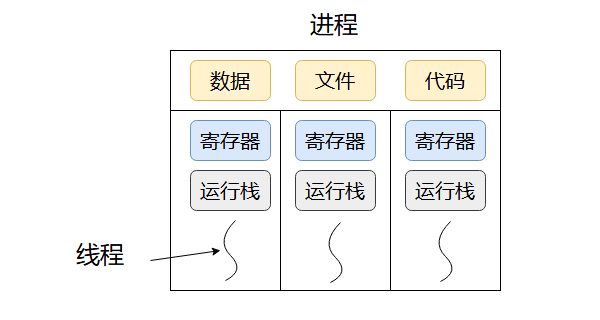

从上图看到，**一个进程拥有多个并发的执行线程**。多个线程共享相同的上下文（数据、文件等），线程间的数据共享和通信更加容易。

**进程之间是相互隔离的，如果多个进程之间要交换数据，必须通过进程间通信机制（Inter-Process Communication，IPC）来实现数据共享，比如多个进程共享内存（multiprocessing.shared_memory）或者消息传递接口（Message Passing Interface，MPI）。**

## 线程安全

由于多个线程共享了上下文（data、files 等），不同线程访问同样数据时，容易产生线程安全（Thread Safe）问题。以这段代码顺序执行为例：

x = x + 1
x = x * 2
x = x - 1
如果这三行计算被调度到三个线程上，数据 x 是被三个线程共享的，三个线程的执行顺序将严重影响计算的结果。下图展示了三种不同的时序可能性，三种时序的计算结果可能各有不同。由于调度时序因素导致的问题，会使得并行计算的结果不符合预期，线程不安全。

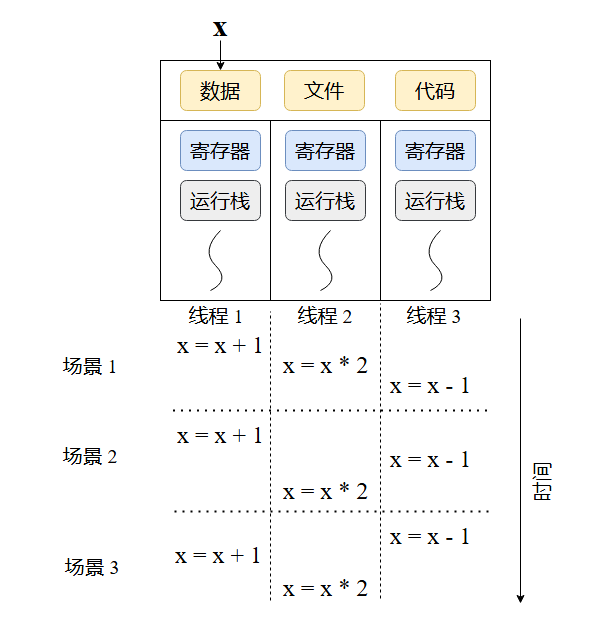

**解决线程安全的最简单办法是加锁。如下图所示，对于共享的数据，每个线程对其进行修改前先加锁，修改完后再释放锁。**

import threading

lock = threading.Lock()

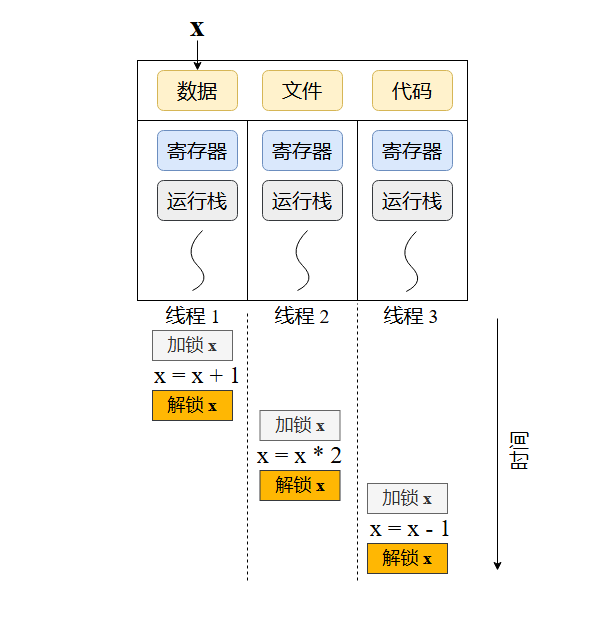

## 全局解释器锁

Python 解释器 CPython 在解决线程安全时使用了一个激进的方式：全局解释器锁（Global Interpreter Lock，GIL）。

CPython 是 Python 解释器的一种实现，也是使用最广泛的一种实现。CPython 主要使用 C 语言实现。我们使用 Anaconda 安装的 Python 就是 CPython。

除了 CPython，还有 Jython，使用Java 实现；IronPython 使用 C# 实现。

GIL 全局解释器锁使得 Python 一个进程下只允许一个线程在运行。GIL 下，一个 Python 进程只能有一个线程运行，也只能利用一个 CPU 核心。GIL 的优势之一就是线程安全；缺点也很明显，在现代单机多核计算机上，Python 以及大部分库比如 NumPy、pandas、scikit-learn 的很多功能只能利用一个核心。

GIL 与整个 Python 生态紧密绑定，它与 NumPy、pandas 等很多库息息相关，移除 GIL 可谓牵一发而动全身。所以，想让 Python 充分利用现代计算机的多核，其实并不那么容易。幸运的是，Python 官方正在解决这个问题，不久的将来，CPython 将移除 GIL。

# 并行程序设计方法

## PCAM

如何设计软件和算法，使得程序可以并行运行在多核或者集群上？早在 1995 年，Ian Foster 在其书中提出了 PCAM 方法 [Foster, 1995]，其思想可以用来指导并行算法的设计。PCAM 主要有四个步骤：切分（Partitioning）、通信（Communication）、聚集（Agglomeration）和分发（Mapping）。

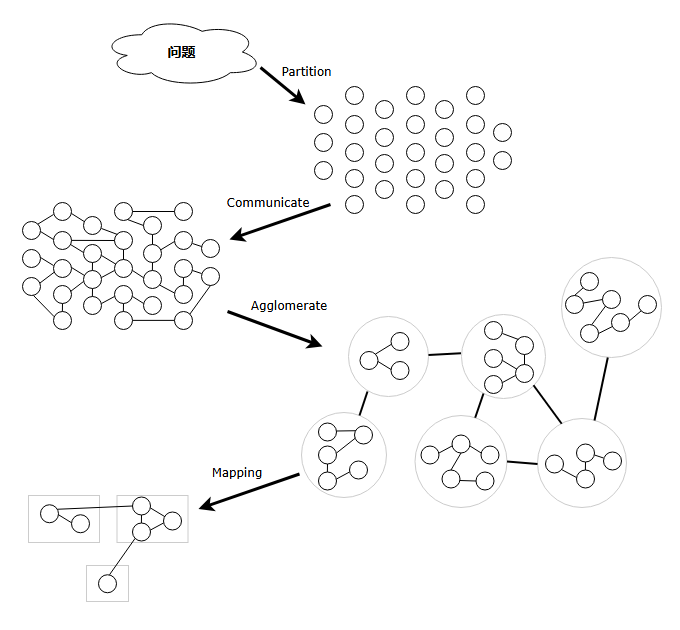

- Partitioning：将整个问题切分为多个子问题或子任务，切分既包括计算部分也包括数据部分。

- Communication：不同子任务之间通信方式，包括通信的数据结构、通信算法。

- Agglomeration：考虑到当前所拥有的硬件性能和编程难度，将上面两步进一步整合，将细粒度的任务整合成更高效的任务。

- Mapping：将整合好的任务分发给多个处理器。

比如，有一个超大矩阵，矩阵大小为 M\*M
，这个矩阵大到无法放在单个计算节点上计算，现在想得到这个矩阵的最大值。设计并行算法时，可以考虑如下思路：

将矩阵切分成子矩阵，每个子矩阵 m\*m
 大小，在每台计算节点上执行 max() 函数求得子矩阵的最大值。

将每个子矩阵的最大值汇集到一个计算节点，再该节点再次执行一下 max() 求得整个矩阵的最大值。

 m\*m大小的子矩阵 max() 可以在单个计算节点上运行。

将以上计算分发到多个节点。

## 切分方式

设计并行程序最困难也是最关键的部分是如何进行切分，常见的切分方式有：

- 任务并行：一个复杂的程序往往包含多个任务，将不同的任务交给不同的 Worker，如果任务之间没有太多复杂的依赖关系，这种方式可以很好地并发执行。

- 几何分解：所处理的数据结构化，比如矩阵可以根据一维或多维分开，分配给不同的 Worker，刚才提到的对矩阵求最大值就是一个例子。

## 案例：MapReduce

Google 2004 年提出 MapReduce [Dean and Ghemawat, 2004]，这是一种典型的大数据并行计算范式。下图展示了使用 MapReduce 进行词频统计的处理方式。

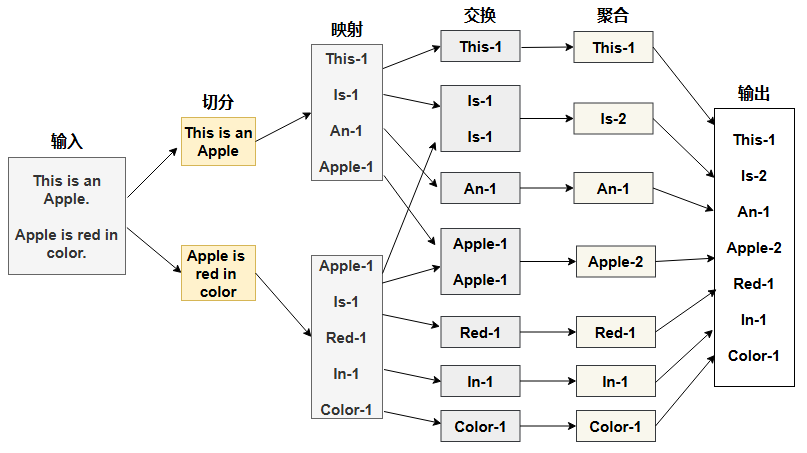

MapReduce 中主要涉及四个阶段：

- 切分（Split）：将大数据切分成很多份小数据，每份小数据可以在单个 Worker 上计算。

- 映射（Map）：对每个小数据执行 Map 操作，Map 是一个函数映射，程序员需要自定义 Map 函数，Map 函数输出一个键值对（Key-Value）。在词频统计的例子中，每出现一个词，计 1 次，Key 是词，Value 是 1，表示出现 1 次。

- 交换（Shuffle）：将相同的 Key 归结到相同的 Worker 上。这一步涉及数据交换。词频统计的例子中，将相同的词发送到同一个 Worker 上。

- 聚合（Reduce）：所有相同的 Key 进行聚合操作，程序员需要自定义 Reduce 函数。词频统计的例子中，之前 Shuffle 阶段将已经将相同的 Key 归结到了一起，现在只需要将所有词频求和。

MapReduce 的编程范式深刻影响了 Apache Hadoop、Apache Spark、Dask 等开源项目。